In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# downloading the mnist dataset (each image is of size 28*28)
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape, y.shape)

(70000, 784) (70000,)


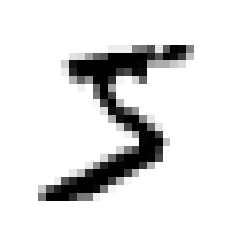

5


In [4]:
# viewing sample images
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

print(y[0])

In [5]:
# converting the target values into numbers
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [6]:
# splitting into train and test (MNIST is already shuffled and split in 60000:10000)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classification

In [7]:
# ***SIMPLIFIED PROBLEM:  the 5 detector***
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## Stochastic Gradient Descent Classifier

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

# predicting the output 
predictions = sgd_clf.predict(X_test)
predictions

array([False, False, False, ..., False,  True, False])

In [9]:
# metrics (test set accuracy)
from sklearn.model_selection import cross_val_score

# using three folds in cross validation
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9684 , 0.96795, 0.9412 ])

In [10]:
from sklearn.model_selection import cross_val_predict

# croos_val_predict helps give the cross validation values which are compared with y_train_5
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [11]:
# printing confusion matrix for the 5 predictor
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53735,   844],
       [ 1334,  4087]], dtype=int64)

In [12]:
# precision and recall

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

print({'precision': precision, 'recall': recall})

{'precision': 0.8288379639018455, 'recall': 0.7539199409703007}


In [13]:
# computing the F1 score (harmonic mean of precision and recall)
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)
# F1 score depends on both precision and recall being high and close to each other

0.7896058732612056

### How does Stochastic Gradient descent work?

- SGD classifier decides on a threshold value and based on which side of threshold the decision functions output falls it predicts a class 

In [14]:
# accessing the SGD classifiers decision function
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2808.25239687])

In [15]:
# starting with a threshold value of 0 
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

# changing the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]
[False]


### How to decide on what threshold to use?
- It depends on the precision and recall values you are looking for

In [16]:
# getting the cross_Val_predictions but for decision function instead of classifier output
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [17]:
# getting the precision and recall values for all thresholds (possible)
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

### Precision, Recall Curve

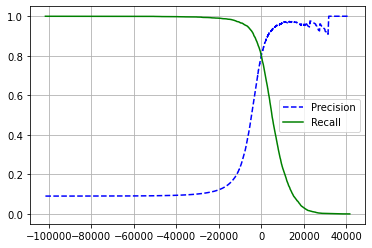

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.grid()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Lets say we want a high precision system (precision > 90%):
- in the above plot we can see that when precision is at 90% recall has a low value of around 30-50%


In [19]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

2904.6093418986356

In [20]:
# Now we can use this thresold for a system with 90% precision instead of SGD's predict method
y_train_pred_90 = (y_scores >= threshold_90_precision)

# printing precision and recall scores
precision = precision_score(y_train_5, y_train_pred_90)
recall = recall_score(y_train_5, y_train_pred_90)

print({'precision': precision, 'recall': recall})

{'precision': 0.9000521920668059, 'recall': 0.6362294779560966}


### ROC Curve
- The Receiver Operating Characteristics curve
- This Curve is plot between True Positive Rate (Recall) and False Positive Rate

In [21]:
from sklearn.metrics import roc_curve

FPR, TPR, thresholds = roc_curve(y_train_5, y_scores)

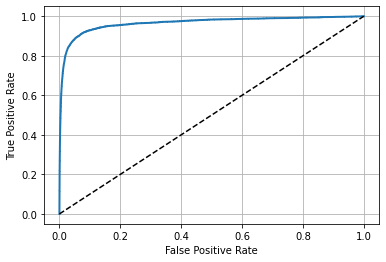

In [22]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis()
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(FPR, TPR)

A good model will have the blue curve as far away from the black line as possible.
This can be measured quantitatively by using the Area under curve as a metric

In [23]:
from sklearn.metrics import roc_auc_score

area_under_curve = roc_auc_score(y_train_5, y_scores)
area_under_curve

0.9654433005777325

#### As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve

## Random Forest Classifier

Note:  Random Forest Classifier doesn't have the decision_function as in SGDClassifier instead we have predict_proba()

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')

In [26]:
y_scores_forest = y_probas_forest[:, 1]
FPR_forest, TPR_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

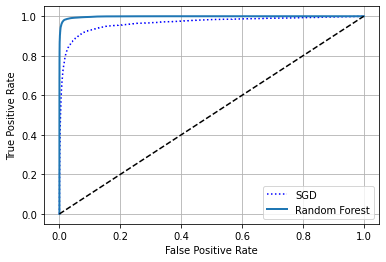

In [27]:
plt.plot(FPR, TPR, "b:", label="SGD")
plot_roc_curve(FPR_forest, TPR_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [28]:
# area under curve for Random Forest Classifier
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [29]:
# measuring precison and recall scores for RandomForestClassifier
y_predictions_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict')
precision = precision_score(y_train_5, y_predictions_forest)
recall = recall_score(y_train_5, y_predictions_forest)

print({'precision': precision, 'recall': recall})

{'precision': 0.9905083315756169, 'recall': 0.8662608374838591}


# MultiClass Classification

## Support Vector Classifier
- Though Support Vector Machine is strictly a binary classifier, Scikit learn can detect the multiclass utility and apply one vs one (or) one vs the Rest strategy

In [30]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [31]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [32]:
# all detected classes are stored in classes_
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [33]:
# to Forcefully use OvO or OvR we can use wrapper classifiers
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [34]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [35]:
# training aan SGD classifier for multiple classes
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [36]:
# scores of the decision function are matching the prediction
sgd_clf.decision_function([some_digit])

array([[-13377.7217518 , -20530.24043226,  -6039.90039263,
         -2162.68205356, -16884.88315489,   2543.71161303,
        -18367.31730386, -17978.07781607,  -6552.08256711,
        -11766.50984525]])

In [37]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8825 , 0.8824 , 0.86715])

In [38]:
# Scaling the inputs will improve the accuracy further 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.89535, 0.89415, 0.89955])

# Error analysis

In [39]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5581,    0,   25,    5,    9,   46,   36,    6,  214,    1],
       [   0, 6404,   37,   26,    4,   44,    4,    8,  203,   12],
       [  26,   27, 5255,   92,   73,   27,   67,   38,  343,   10],
       [  23,   17,  119, 5243,    2,  210,   27,   40,  375,   75],
       [  12,   14,   47,   10, 5208,   11,   36,   26,  309,  169],
       [  28,   16,   29,  171,   54, 4470,   77,   16,  495,   65],
       [  31,   15,   45,    2,   43,   97, 5559,    3,  122,    1],
       [  20,   10,   52,   28,   51,   11,    3, 5698,  171,  221],
       [  17,   64,   49,   88,    3,  126,   25,   10, 5423,   46],
       [  21,   19,   31,   65,  121,   36,    1,  176,  337, 5142]],
      dtype=int64)

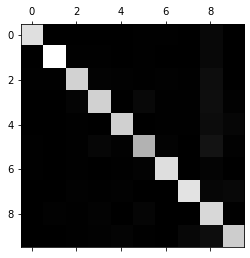

In [40]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [41]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

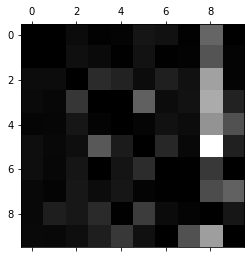

In [42]:
# error plot

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

8 is having many mis classifications. We can analyse this as an issue.

In [43]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# Multilabel classification

associating multiple labels with every entry.

In [47]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)   # label to represent if the value is greater than 6
y_train_odd = (y_train % 2 == 1)  # label to represent if the value is even or odd
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [48]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
# evaluating the multilabel classifier

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# MultiOutput Classification

Systems which give out multiple labels per output. And also produce multiple outputs.

In [ ]:
# adding noice to existing MNIST images

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)